In [1]:
import numpy as np
import pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from cvxopt import matrix
from cvxopt.solvers import qp

In [2]:
class MeanStdTradeoff(pymoo.core.problem.Problem):
    def __init__(self, probabilistic_model):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([0,0]), xu=np.array([0,0]))
        self.probabilistic_model = probabilistic_model

    def _evaluate(self, x, out, *args, **kwargs):
        mean,var = self.probabilistic_model.predict_y(x)
        std = np.sqrt(np.array(var))
        out["F"] = np.concatenate([np.array(mean), std], axis=1)

class BatchHypervolumeSharpeRatioIndicator:

    def __init__(self, population_size:int =500, replication=False):

        self.population_size = population_size
        self.replication = replication

    def _find_non_dominated_points(self, model):
        """Uses NSGA-II to find high-quality non-dominated points
        """

        problem = MeanStdTradeoff(model)
        algorithm = NSGA2(pop_size=self.population_size)
        res = minimize(problem, algorithm, ('n_gen', 200), seed=1, verbose=False)

        return res.X, res.F

    
    def __call__(self, model, batch_size):

        # Find non-dominated points in the mean/std space
        nd_points, nd_mean_std = self._find_non_dominated_points(model)

        # TODO alex: Add PI filtering here 

        # Calculate p matrix
        p = self._calc_p(nd_mean_std)

        # Optimise (y^T)Py - 1 as we do not have risk free assets
        x_star = self._find_x_star(p)

        # Select batch to observe
        batch = self._get_batch(x_star, nd_points, batch_size)

        return batch


    def _calc_p(self, a):

        # First determine suitable l and u values for the reference points

        # According to (the text before) Theorem 1 in Guerreiro and Fonesca (2016)
        #  we can just set l to be the min of each dimension
        l = (float(min(a[:, 0])), float(min(a[:, 1])))

        # We need u to be much higher than mean or std
        u = (np.abs(float(min(a[:, 0]))) * 1e5, np.abs(float(min(a[:, 1]))) * 1e5) # TODO alex: Check this is the correct thing to do

        # Calculate matrix P

        # Out is square matrix determined by number of points in a
        p = np.zeros([a.shape[0], a.shape[0]])

        # Can calculate denominator for each element upfront
        denominator = (u[0] - l[0]) * (u[1] - l[1]) ** 2

        # Fill in entries of P
        for i in range(p.shape[0]):
            for j in range(p.shape[0]):
                p[i,j] = ((u[0] - max(a[i, 0],a[j, 0])) * (u[1] - max(a[i, 1], a[j, 1])))

        p /= denominator

        return p

    def _find_x_star(self, p):

        n_pts = p.shape[0]

        # We need to find r, for the sum to one condition
        r = np.diagonal(p)

        # Use Quadratic Programming to find y*
        # The cvxopt QP solver solves the problem:
        # minimise (1/2)(x^T)Px + (q^T)x
        # subject to Gx <= h (elementwise)
        #        and  Ax = b

        # The minimisation problem we have is:
        # minimise (y^T)Py
        # subject to y >= 0 (elementwise)
        #        and (r^T)y = 1     

        # Therefore we define the inputs as follows
        # P is already correct
        P = matrix(p)

        # We don't have a q term, so just create zeros in the correct shape
        q = matrix(np.zeros([n_pts, 1]))

        # We want to flip the inequality, and just maintain the values of y with G
        # So we set it to -I
        G = matrix(-1*np.eye(n_pts))

        # We want each element to be greater than zero, so we set h to a zero vector
        h = matrix(np.zeros([n_pts, 1]))

        # We want to sum each element of r*y, so we make A a vector of r
        A = matrix(np.expand_dims(r, axis=0))

        # We want the elements to sum to 1, so b is just 1
        b = matrix(np.ones([1,1]))

        # Now we can perform the optimisation
        optim = qp(P=P,q=q,G=G,h=h,A=A,b=b)

        # Extract y* from the optimiser output
        y_star = np.array(optim["x"])

        # Calculate x*
        x_star = y_star / np.sum(y_star)

        return x_star

    def _get_batch(self, x_star, nd_points, batch_size):

        
        sorted_array = self._sort_points_by_x_star(x_star, nd_points)

        
        if self.replication:
            raise NotImplementedError
        else:
            if batch_size <= sorted_array.shape[0]:
                return sorted_array[:batch_size,1:]
            else:
                raise ValueError("Batch size greater than number of non-dominated points")


    def _sort_points_by_x_star(self, x_star, nd_points):

        x_star_and_points = np.concatenate([x_star, nd_points], axis=1)
        sorted_array = x_star_and_points[x_star_and_points[:,0].argsort()[::-1]]
        return sorted_array


# Trying it out

In [3]:
from trieste.objectives import scaled_branin
from trieste.objectives.utils import mk_observer
from trieste.space import Box

# Create the observer
observer = mk_observer(scaled_branin)

# Define Search space
search_space = Box([0,0], [1,1])

# Set initial number of query points
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

2022-07-29 08:50:26.403509: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 08:50:26.403534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-29 08:50:28.004324: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-29 08:50:28.004448: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 08:50:28.004457: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 08:50:28.004471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

In [4]:
from trieste.models.gpflow import GaussianProcessRegression, build_gpr

# Set up model
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

2022-07-29 08:50:28.123874: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
# Set up rule

qhsri = BatchHypervolumeSharpeRatioIndicator()

points_chosen_by_qhsri = qhsri(model, 5)


/home/alexander.goodall/.venv/trieste/lib/python3.8/site-packages/pymoo/operators/mutation/pm.py:34: RuntimeWarning: divide by zero encountered in divide
  delta1 = (X - xl) / (xu - xl)
/home/alexander.goodall/.venv/trieste/lib/python3.8/site-packages/pymoo/operators/mutation/pm.py:34: RuntimeWarning: invalid value encountered in divide
  delta1 = (X - xl) / (xu - xl)
/home/alexander.goodall/.venv/trieste/lib/python3.8/site-packages/pymoo/operators/mutation/pm.py:35: RuntimeWarning: divide by zero encountered in divide
  delta2 = (xu - X) / (xu - xl)
/home/alexander.goodall/.venv/trieste/lib/python3.8/site-packages/pymoo/operators/mutation/pm.py:35: RuntimeWarning: invalid value encountered in divide
  delta2 = (xu - X) / (xu - xl)
/home/alexander.goodall/.venv/trieste/lib/python3.8/site-packages/pymoo/operators/mutation/pm.py:56: RuntimeWarning: invalid value encountered in multiply
  _Y = X + deltaq * (xu - xl)


     pcost       dcost       gap    pres   dres
 0:  1.5292e+03 -1.5569e+03  3e+03  0e+00  1e+03
 1:  1.5292e+03  1.4983e+03  3e+01  2e-13  1e+01
 2:  1.5292e+03  1.5289e+03  3e-01  2e-13  1e-01
 3:  1.5292e+03  1.5292e+03  4e-02  3e-13  2e-02
 4:  1.5292e+03  1.5292e+03  2e-02  7e-13  2e-16
 5:  1.5292e+03  1.5292e+03  1e-03  1e-13  5e-16
Optimal solution found.


In [6]:
from trieste.acquisition.function import BatchMonteCarloExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization


# Batch MCEI requires a number of monte carlo samples to do
monte_carlo_sample_size = 1000
# Set up batch MCIE builder
batch_ei_acq = BatchMonteCarloExpectedImprovement(
    sample_size=monte_carlo_sample_size,
    jitter = 1e-5
)
# Set up batch EGO acquisition rule
batch_size = 5
batch_ei_acq_rule = EfficientGlobalOptimization(
    num_query_points=batch_size,
     builder=batch_ei_acq)

# Use acquisition rule to pick new points
points_chosen_by_batch_ei = np.array(batch_ei_acq_rule.acquire_single(search_space, model, dataset=initial_data))

2022-07-29 08:50:40.290745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-29 08:50:40.320041: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz
2022-07-29 08:50:40.351774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2022-07-29 08:50:41.358336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


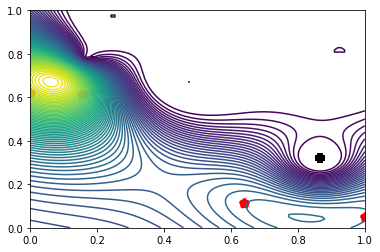

In [7]:
import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_acq_function_2d

from trieste.acquisition.function import ExpectedImprovement

# plot standard EI acquisition function
ei = ExpectedImprovement()
ei_acq_function = ei.prepare_acquisition_function(model, dataset=initial_data)
plot_acq_function_2d(
    ei_acq_function, [0, 0], [1, 1], contour=True, grid_density=100
)

plt.scatter(
    points_chosen_by_batch_ei[:, 0],
    points_chosen_by_batch_ei[:, 1],
    color="red",
    lw=5,
    label="Batch-EI",
    marker="*",
    zorder=1,
)
plt.scatter(
    points_chosen_by_qhsri[:, 0],
    points_chosen_by_qhsri[:, 1],
    color="black",
    lw=10,
    label="Local \nPenalization",
    marker="+",
)
plt.show()
